In [1]:
!pip install librosa matplotlib mutagen pandas torch

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

# EDA

In [7]:
import os
import librosa

train_folder = 'train'
for f in os.listdir(train_folder):
    if f.endswith('.wav'):
        path = os.path.join(train_folder, f)
        y, sr = librosa.load(path, sr=None)  # Load with original sample rate
        if sr != 16000:
            print(f"{f} has sample rate {sr}")

# Nothings gets printed, so all files are 16000 Hz

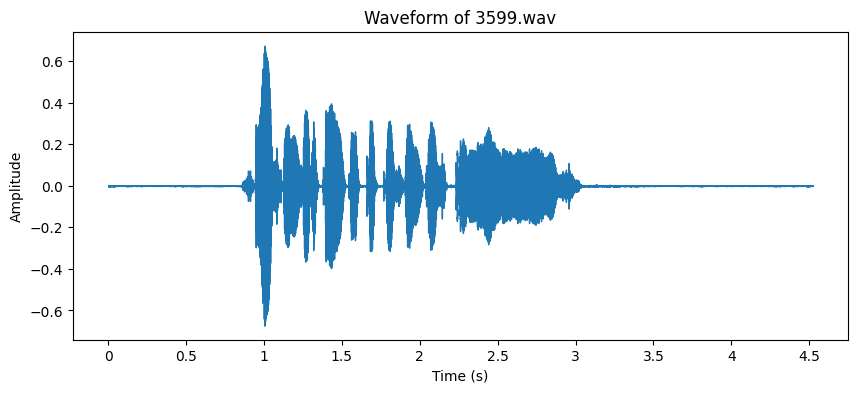

In [2]:
# Loading an example file
audio_path = 'Test set/3599.wav'
y, sr = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of 3599.wav')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [3]:
import os
import librosa

train_folder = 'train'
train_wav_files = [f for f in os.listdir(train_folder) if f.endswith('.wav')]
print(f"Number of .wav files in train folder: {len(train_wav_files)}")

total_duration = 0
for f in train_wav_files:
    y, sr = librosa.load(os.path.join(train_folder, f), sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    total_duration += duration

avg_duration = total_duration / len(train_wav_files)
print(f"Average duration: {avg_duration:.2f} seconds")

speaker_ids = {filename.split('_')[0] for filename in train_wav_files}
male_speakers = [s for s in speaker_ids if s.endswith('m')]
female_speakers = [s for s in speaker_ids if s.endswith('f')]

print(f"Total unique speakers: {len(speaker_ids)}")
print(f"Male speakers: {len(male_speakers)}")
print(f"Female speakers: {len(female_speakers)}")
print("\nMale speaker IDs:", sorted(male_speakers))
print("Female speaker IDs:", sorted(female_speakers))


Number of .wav files in train folder: 3166
Average duration: 5.26 seconds
Total unique speakers: 10
Male speakers: 5
Female speakers: 5

Male speaker IDs: ['1m', '2m', '3m', '4m', '5m']
Female speaker IDs: ['1f', '2f', '3f', '4f', '5f']


Minimum duration: 1.67 seconds
Maximum duration: 12.97 seconds
Standard deviation: 1.74 seconds


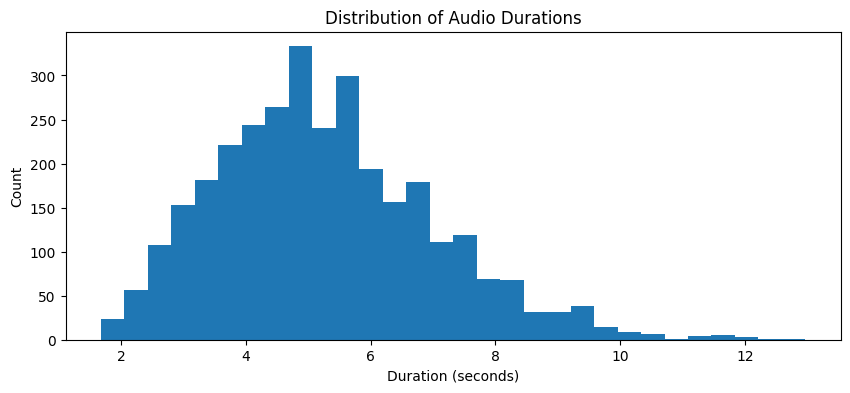

In [4]:
durations = []
for f in train_wav_files:
    y, sr = librosa.load(os.path.join(train_folder, f), sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    durations.append(duration)

min_duration = min(durations)
max_duration = max(durations)
std_duration = np.std(durations)

print(f"Minimum duration: {min_duration:.2f} seconds")
print(f"Maximum duration: {max_duration:.2f} seconds")
print(f"Standard deviation: {std_duration:.2f} seconds")

plt.figure(figsize=(10, 4))
plt.hist(durations, bins=30)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()


### Interpreting
Skewed to the right (longer tail there). Most audio files between 3 and 7 sec. MOst common durations are around 4.5-6 sec. Few outliers longer than 10 sec, but rare. What to do with outliers?

In [51]:
import wave  # Import the wave module for WAV file handling
with wave.open('Test set/3599.wav', 'rb') as wav:  # Open WAV file in read-binary mode
    print(f"Channels: {wav.getnchannels()}")  # Print number of audio channels
    print(f"Sample width: {wav.getsampwidth()}")  # Print sample width in bytes - This shows how many bytes are used to store each audio sample (e.g., 2 bytes = 16-bit audio)
    print(f"Frame rate: {wav.getframerate()}")  # Print sampling frequency
    print(f"Frames: {wav.getnframes()}")  # Print total number of frames
    print(f"Parameters: {wav.getparams()}")  # Print all WAV file parameters



# The accent is encoded in the first character of the file name with a single number from 1 to 5. The gender is encoded as a single letter (’m’ or ’f’) corresponding to the second character of the file name.". 

Channels: 1
Sample width: 2
Frame rate: 16000
Frames: 72363
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=72363, comptype='NONE', compname='not compressed')


In [5]:
from mutagen.wave import WAVE

audio = WAVE('Test set/3599.wav')
print(audio.tags)  # print None if there are no tags

None


In [6]:
# Create a list to store our dataset information
dataset_manifest = []

for file_path in train_wav_files:
    # Extract filename without extension
    filename = os.path.basename(file_path).split('.')[0]
    
    # Extract accent (first character) and convert to 0-based index
    accent = int(filename[0]) - 1  # Convert 1-5 to 0-4
    
    # Extract gender (second character)
    gender = filename[1]
    
    # Create dictionary with file information
    file_info = {
        'file_path': file_path,
        'accent': accent,
        'gender': gender
    }
    
    dataset_manifest.append(file_info)

# Convert to DataFrame for easier manipulation
df_manifest = pd.DataFrame(dataset_manifest)

# Display first few rows and basic statistics
print("Dataset Manifest Preview:")
print(df_manifest.head())
print("\nDataset Statistics:")
print(f"Total files: {len(df_manifest)}")
print("\nAccent distribution:")
print(df_manifest['accent'].value_counts().sort_index())
print("\nGender distribution:")
print(df_manifest['gender'].value_counts())


Dataset Manifest Preview:
     file_path  accent gender
0  2m_9039.wav       1      m
1  4f_1887.wav       3      f
2  4f_9571.wav       3      f
3  1m_3736.wav       0      m
4  1m_3078.wav       0      m

Dataset Statistics:
Total files: 3166

Accent distribution:
accent
0    740
1    626
2    564
3    754
4    482
Name: count, dtype: int64

Gender distribution:
gender
f    1639
m    1527
Name: count, dtype: int64


In [9]:
%who

DataLoader	 F	 WAVE	 accent	 audio	 audio_path	 avg_duration	 dataset_manifest	 df_manifest	 
duration	 durations	 f	 female_speakers	 file_info	 file_path	 filename	 gender	 librosa	 
male_speakers	 max_duration	 min_duration	 nn	 np	 optim	 os	 pack_padded_sequence	 pad_packed_sequence	 
pad_sequence	 path	 pd	 plt	 speaker_ids	 sr	 std_duration	 torch	 total_duration	 
train_folder	 train_test_split	 train_wav_files	 y	 


# Preprocessing

In [15]:
import os
import torch
import torchaudio
import pandas as pd

def load_and_preprocess_audios_from_folder(folder_path, target_sr=16000):
    """
    Load and normalize all audio files in a folder using torchaudio, extracting accent and gender from filename.

    Args:
        folder_path (str): Path to folder containing .wav files
        target_sr (int): Sampling rate

    Returns:
        pd.DataFrame: DataFrame with columns ['file_path', 'waveform', 'accent', 'gender']
    """
    data = []
    for fname in os.listdir(folder_path):
        if fname.endswith('.wav'):
            file_path = os.path.join(folder_path, fname)
            # Load audio
            waveform, sr = torchaudio.load(file_path)
            # Resample if needed
            if sr != target_sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
                waveform = resampler(waveform)
            # Convert to mono if not already
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            # Normalize amplitude
            waveform = waveform / waveform.abs().max()
            # Extract accent and gender
            accent = int(fname[0])  # 1-5
            gender = fname[1]       # 'm' or 'f'
            data.append({
                'file_path': file_path,
                'waveform': waveform,
                'accent': accent,
                'gender': gender
            })
    return pd.DataFrame(data)

df = load_and_preprocess_audios_from_folder("/Users/larsheijnen/DL/Train")
print(df.head())

#Size first waveform
print(df['waveform'].iloc[0].shape)


                                 file_path  \
0  /Users/larsheijnen/DL/Train/2m_9039.wav   
1  /Users/larsheijnen/DL/Train/4f_1887.wav   
2  /Users/larsheijnen/DL/Train/4f_9571.wav   
3  /Users/larsheijnen/DL/Train/1m_3736.wav   
4  /Users/larsheijnen/DL/Train/1m_3078.wav   

                                            waveform  accent gender  
0  [[tensor(-0.0001), tensor(-0.0001), tensor(-5....       2      m  
1  [[tensor(0.), tensor(4.4749e-05), tensor(0.), ...       4      f  
2  [[tensor(-0.0001), tensor(-0.0002), tensor(-0....       4      f  
3  [[tensor(-0.0003), tensor(-0.0003), tensor(-0....       1      m  
4  [[tensor(-0.0008), tensor(-0.0009), tensor(-0....       1      m  
torch.Size([1, 41400])
